## Описание

Задача бинарной классификации сообщений из Телеграма на спам. В качестве датасета размеченные данные из Телеграма за один месяц.
Проект описывает этапы препроцессинга, EDA, векторного преобразования слов с последующей классификацией с помощью RandomForest, XGBoost и Catboost. Помимо этого настроим и обучим трансформер BERT с помощью PytorchLighting

In [78]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd

from lightning_transformers.task.nlp.text_classification import (
    TextClassificationDataModule,
    TextClassificationTransformer,
)
from transformers import AutoTokenizer
# from glob import glob

from sklearn import metrics
from vectorizer import TfidfEmbeddingVectorizer
import re
import numpy as np
import pickle
from pymystem3 import Mystem
from gensim.models import Word2Vec
from catboost import CatBoostClassifier


In [79]:
train_path=os.path.join('dataset','train.json')
test_path=os.path.join('dataset','test.json')
eval_path=os.path.join('dataset','eval.json')
df_path=os.path.join('dataset','df.json')
report_path = 'result.json'
origin_bert_name = 'bert-base-multilingual-uncased'
modified_bert_name = 'spam-bert-multilingual'
w2v_model_name = 'word2v.model'
catboost_pickle_name = 'cb_w2c.pkl'
automl_filename = 'automl.pkl'
regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")


In [80]:
def show_metrics (y, preds):
    fpr, tpr, thresholds = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot();
    print(metrics.classification_report(y, preds))
    cm=metrics.confusion_matrix(y,preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

def lemmatize(text, mystem=Mystem()):
    try:
        return "".join(mystem.lemmatize(text)).strip()  
    except:
        return " "

def vectorize(vectorizer, text):
    text = text.apply(words_only).apply(lemmatize)
    return vectorizer.fit_transform(text.tolist())

## Препроцессинг файлов

In [81]:
from sklearn.model_selection import train_test_split
import json

Импорт сообщений состоит из бота выдающего сообщения о спаме, а также сотрудника, который посмечает сообщения (SPAM/NO)

In [82]:
employer_id = 'user32512143'
contractor_bot_id = 'user913646289'

Получение и парсинг данных

In [83]:
with open(report_path, 'r', encoding="utf8") as json_file:
    data = json.load(json_file)

data_messages=pd.DataFrame(data['messages'])
data_messages.head(10)

,id,type,date,date_unixtime,from,from_id,forwarded_from,text,text_entities,reply_to_message_id,...,mime_type,duration_seconds,via_bot,poll,performer,title,contact_information,contact_vcard,edited,edited_unixtime
0,9000000,message,2022-08-07T12:45:51,1659858351,Spam Contractor Bot,user913646289,Vân Anh,"[{'type': 'italic', 'text': '🌕 0%'}, \nNạp 1tr...","[{'type': 'italic', 'text': '🌕 0%'}, {'type': ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9000001,message,2022-08-07T12:45:51,1659858351,Spam Contractor Bot,user913646289,NaN,"[{'type': 'hashtag', 'text': '#r785281986'}, ,...","[{'type': 'hashtag', 'text': '#r785281986'}, {...",9000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9000002,message,2022-08-07T12:45:55,1659858355,Kirill Fomenko,user32512143,NaN,😌 NO,"[{'type': 'plain', 'text': '😌 NO'}]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9000003,message,2022-08-07T12:45:55,1659858355,Spam Contractor Bot,user913646289,NaN,"[Report , {'type': 'hashtag', 'text': '#r78528...","[{'type': 'plain', 'text': 'Report '}, {'type'...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9000004,message,2022-08-07T12:45:55,1659858355,Spam Contractor Bot,user913646289,Артём Грузнов,"[{'type': 'italic', 'text': '🌚 100%'}, \n❗ВНИМ...","[{'type': 'italic', 'text': '🌚 100%'}, {'type'...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9000005,message,2022-08-07T12:45:55,1659858355,Spam Contractor Bot,user913646289,NaN,"[{'type': 'hashtag', 'text': '#r782066297'}, ,...","[{'type': 'hashtag', 'text': '#r782066297'}, {...",9000004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9000006,message,2022-08-07T12:45:56,1659858356,Kirill Fomenko,user32512143,NaN,😡 SPAM,"[{'type': 'plain', 'text': '😡 SPAM'}]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9000007,message,2022-08-07T12:45:56,1659858356,Spam Contractor Bot,user913646289,NaN,"[Report , {'type': 'hashtag', 'text': '#r78206...","[{'type': 'plain', 'text': 'Report '}, {'type'...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9000008,message,2022-08-07T12:45:56,1659858356,Spam Contractor Bot,user913646289,Nguyễn Thị Bích Liên,"[{'type': 'italic', 'text': '🌕 0%'}, \n, {'typ...","[{'type': 'italic', 'text': '🌕 0%'}, {'type': ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9000009,message,2022-08-07T12:45:56,1659858356,Spam Contractor Bot,user913646289,NaN,"[{'type': 'hashtag', 'text': '#r786017572'}, ,...","[{'type': 'hashtag', 'text': '#r786017572'}, {...",9000008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пример сообщений

In [84]:
data_messages['text'][:10].values

array([list([{'type': 'italic', 'text': '🌕 0%'}, '\nNạp 1tr km 500k 2 vòng cược ai qt ib em ( đạt chỉ tiêu được bank thêm 200k )']),
       list([{'type': 'hashtag', 'text': '#r785281986'}, ', 😱11\n', {'type': 'bold', 'text': 'Source:'}, ' Trường Giang - DOMINO - ( Baccarat&#39;… ', {'type': 'mention', 'text': '@truonggiang7979'}, '\n', {'type': 'bold', 'text': 'Sender:'}, ' 🇻🇳 VNM, Vân Anh , ', {'type': 'mention', 'text': '@anhxinh68'}, '\n07.08.22, 07:43  🌕 0%\n', {'type': 'bot_command', 'text': '/pattern785281986'}, ' · ', {'type': 'bot_command', 'text': '/abuse785281986'}, ' · ', {'type': 'bot_command', 'text': '/eng785281986'}, '']),
       '😌 NO',
       list(['Report ', {'type': 'hashtag', 'text': '#r785281986'}, ' marked as not spam 😌\nSend ', {'type': 'bot_command', 'text': '/undo785281986'}, ' to revert your decision.']),
       list([{'type': 'italic', 'text': '🌚 100%'}, '\n❗ВНИМАНИЯ❗\n\n Успей купить по выгодной цене \n⤵️Личные кабинеты банков 🏦\n\n✅Moneybase\n✅Revolut, \n✅

In [85]:
data_messages.shape

(1057393, 27)

Заводим массив сообщений, каждый раз когда когда пользователь даёт оценку, сохраняем сообщение, когда "говорит" бот запоминаем текст сообщения и его автора

In [86]:
messages = []
msg = {}
text=''

for message in data['messages']:
    if message.__contains__('from_id'):
        if (message['from_id']==employer_id):
            marked = False
            if (message['text']=='😌 NO'):
                msg['spam']=0
                marked = True

            if (message['text']=='😡 SPAM'):
                msg['spam']=1
                marked = True

            if (marked):
                msg['id']=message['id']
                msg['text']=text.replace('\n',' ')
                text=''
                msg={}
                messages.append(msg)

                
        if (message['from_id']==contractor_bot_id):
            if (message.__contains__('forwarded_from')):
                if (message['forwarded_from'] is not None):
                    msg['author'] = message['forwarded_from']
                    
                for each in message['text'][1:]:
                    if (type(each)==str):
                        text+=' '+each
                    elif each.__contains__('type'):
                        if each['type']=='link':
                            msg['link']=1
                        text+=' '+each['text']
                
                

            if (message.__contains__('reply_to_message_id')):
                if message['text'][0]=='🔴 ':
                    msg['source']=message['text'][4]
                else:
                    msg['source']=message['text'][3]
        
df=pd.DataFrame(messages).fillna(0)        

### EDA

In [87]:
df.describe(include='all')

,author,source,spam,id,text,link
count,257856.0,257856,257856.000000,2.578560e+05,257856,257856.000000
unique,141830.0,121055,NaN,NaN,179024,NaN
top,0.0,,NaN,NaN,,NaN
freq,55633.0,6114,NaN,NaN,17029,NaN
mean,NaN,NaN,0.521702,9.466446e+06,NaN,0.204029
std,NaN,NaN,0.499530,3.129677e+05,NaN,0.402991
min,NaN,NaN,0.000000,0.000000e+00,NaN,0.000000
25%,NaN,NaN,0.000000,9.195241e+06,NaN,0.000000
50%,NaN,NaN,1.000000,9.464955e+06,NaN,0.000000
75%,NaN,NaN,1.000000,9.738300e+06,NaN,0.000000


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257856 entries, 0 to 257855
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   author  257856 non-null  object 
 1   source  257856 non-null  object 
 2   spam    257856 non-null  float64
 3   id      257856 non-null  float64
 4   text    257856 non-null  object 
 5   link    257856 non-null  float64
dtypes: float64(3), object(3)
memory usage: 11.8+ MB


Почистим данные по длине строки

<AxesSubplot:>

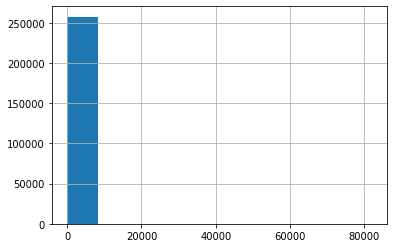

In [89]:
df['len_text']=df['text'].astype('str').apply(lambda x: len(x))
df['len_text'].hist()

<AxesSubplot:>

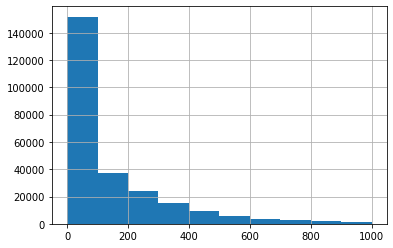

In [90]:
df[df['len_text']<1000]['len_text'].hist()

<AxesSubplot:title={'center':'len_text'}, xlabel='spam'>

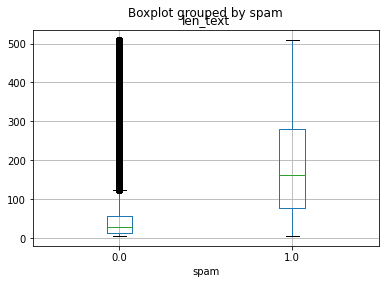

In [91]:
IQR = df['len_text'].quantile(0.75) - df['len_text'].quantile(0.25)
up_bound = df['len_text'].quantile(0.75) + (IQR * 1.5)
df = df[(df['len_text']>5) & (df['len_text']<up_bound)]
df.boxplot(column='len_text', by='spam')

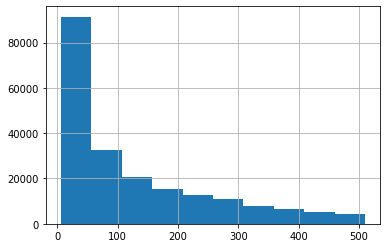

In [92]:
df['len_text'].hist();

Объединяем автора сообщения с самим сообщением (Бывает случаи когда "тело" спама находится в имени автора)

In [77]:
# df.text = df.author.astype(str).str.cat(df.text)

Делим выборку на тренировочную, тестовую и проверочную

In [93]:
df_save = df[['spam','text', 'author', 'source']]
df_save.columns = ['label','text', 'author', 'source']
train_test, eval = train_test_split(df_save, train_size=0.9)
train, test = train_test_split(train_test, train_size=0.9)

In [26]:
test.head()

,label,text
236169,0.0,"FILL Привет, кто со мной мяукать??"
200933,0.0,Pr0v0 C//p Pr0v0 🔞🔥
205894,1.0,Cskhgiftcode 🎁 CODE 300K 𝐕𝐔𝐀𝟔𝟗CLUB ✅ FULL COD...
115619,1.0,0 🚨PLEASE PAY ATTENTION🚨 Telegram is now home...
120610,0.0,𝑷𝒐'𝒙𝒙𝒐𝒚 𝑹𝒆𝒋𝒊𝒎.......𝑶𝒏 Mengga qara hurmatli l...


Сохранение разметки

In [94]:
train.to_json(train_path,orient='records', force_ascii=False)
test.to_json(test_path,orient='records', force_ascii=False)
eval.to_json(eval_path,orient='records', force_ascii=False)
df_save.to_json(df_path,orient='records', force_ascii=False)

## Word-2-Vec + CatBoost

Преобразуем слова в пространство векторов и классифицируем несколькими алгоритмами

In [4]:

# import numpy as np
# from sklearn.compose import make_column_selector
# import xgboost
# import catboost

In [13]:
df_save=pd.read_json(df_path,orient='records')
train=pd.read_json(train_path,orient='records')
test=pd.read_json(test_path,orient='records')

In [14]:
words_only('Проверка 1 лемматизации и 1 проверки на слова :))')

'Проверка лемматизации и проверки на слова :))'

### Подготовка модели Word2vec

In [15]:
%time df_save.text = df_save.text.apply(words_only)
%time df_save.text = df_save.text.apply(lemmatize)

CPU times: user 1.02 s, sys: 19.8 ms, total: 1.04 s
Wall time: 1.13 s
CPU times: user 10.1 s, sys: 1.19 s, total: 11.3 s
Wall time: 1min 3s


In [9]:
texts = [df_save.text.iloc[i].split() for i in range(len(df_save))]

In [10]:
%%time
model = Word2Vec(texts, window=5, min_count=5, workers=4)
model.save("word2v.model")

CPU times: user 46.9 s, sys: 3.99 s, total: 50.9 s
Wall time: 22.9 s


In [10]:
model.wv.most_similar("лс")

[('личка', 0.9578715562820435),
 ('ЛС', 0.9501171708106995),
 ('Лс', 0.8801920413970947),
 ('директ', 0.8724393844604492),
 ('лс)', 0.8688517212867737),
 ('л/с', 0.8661670088768005),
 ('ЛС)', 0.863395631313324),
 ('личка!', 0.8515932559967041),
 ('ЛС!', 0.8509644865989685),
 ('ТГ', 0.84438157081604)]

In [11]:
model.wv.most_similar("меф")

[('гаш', 0.9680689573287964),
 ('ск', 0.9653255939483643),
 ('шишка', 0.9432579874992371),
 ('мефедрон', 0.9315119981765747),
 ('кристалл', 0.928811252117157),
 ('гашиш', 0.9156591892242432),
 ('крис', 0.9125720858573914),
 ('метадон', 0.9113448262214661),
 ('гр', 0.896694004535675),
 ('соль', 0.8857972025871277)]

### Классификация

In [16]:
model = Word2Vec.load(w2v_model_name)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

#### Векторизация данных

In [17]:
y_train = train.label.tolist()
y_test = test.label.tolist()

print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

vectorizer = TfidfEmbeddingVectorizer(w2v)
X_train = vectorize(vectorizer, train.text)
X_test = vectorize(vectorizer, test.text)

total train examples 167803
total test examples 18645


#### CatBoost из коробки

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      8696
           1       0.89      0.88      0.89      9949

    accuracy                           0.88     18645
   macro avg       0.88      0.88      0.88     18645
weighted avg       0.88      0.88      0.88     18645



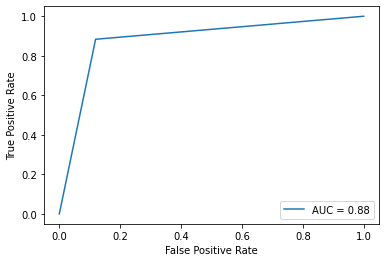

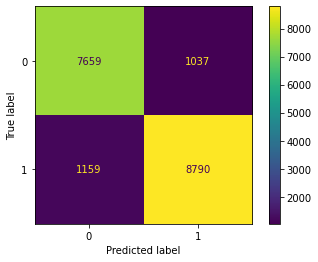

In [16]:
cb_w2c = CatBoostClassifier(verbose=False)
cb_w2c.fit(X_train, y_train)
preds = cb_w2c.predict(X_test)
show_metrics(y_test, preds)

### Кроссвалидация, подбор гиперпараметров

In [23]:
%time df_save.text = df_save.text.apply(words_only).apply(lemmatize)
X = vectorize(vectorizer, df_save.text)

grid = {
        'learning_rate': [0.05, 0.1, 0.3],
        'depth': [5, 10, 12, 15],
        'l2_leaf_reg': [8, 9, 11]
        }
cb_w2c = CatBoostClassifier(verbose=False)
grid_search_result = cb_w2c.grid_search(grid, 
                                       X=X, 
                                       y=df_save.label.tolist(), 
                                       cv=4,
                                       verbose=False,
                                        )



CPU times: user 11.9 s, sys: 1.1 s, total: 13 s
Wall time: 1min 4s

bestTest = 0.2851042443
bestIteration = 999


bestTest = 0.2856334997
bestIteration = 903


bestTest = 0.2874146368
bestIteration = 785

Training on fold [0/4]

bestTest = 0.2924711628
bestIteration = 999

Training on fold [1/4]

bestTest = 0.2884180765
bestIteration = 980

Training on fold [2/4]

bestTest = 0.2883816689
bestIteration = 997

Training on fold [3/4]

bestTest = 0.2867113039
bestIteration = 998



In [26]:
grid_search_result['params']

{'depth': 12, 'l2_leaf_reg': 9, 'learning_rate': 0.05}

{'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.1}

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8696
           1       0.96      0.97      0.97      9949

    accuracy                           0.97     18645
   macro avg       0.97      0.96      0.96     18645
weighted avg       0.97      0.97      0.97     18645



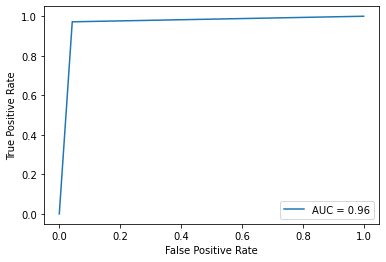

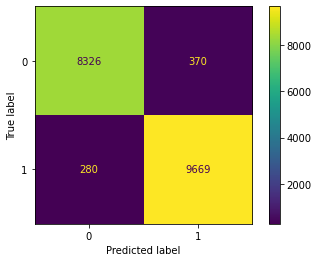

In [27]:
preds = cb_w2c.predict(X_test)
show_metrics(y_test, preds)

In [28]:
cb_w2c.save_model(catboost_pickle_name)

## LAMA
Попробуем Sber AutoML

In [46]:
from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task

In [95]:
# df_save=pd.read_json(df_path,orient='records')
train=pd.read_json(train_path,orient='records')
test=pd.read_json(test_path,orient='records')

In [96]:
train.head()

,label,text,author,source
0,0,yordam kerak Lijga yozglar iLtmos,LAZIZ,❤️YOLGONCHI❤️YORIMNI😍SOGINDIM❤️❤️
1,1,𝙸 𝚌𝚊𝚗’𝚝 𝚔𝚎𝚎𝚙 𝚝𝚑𝚒𝚜 good𝚗𝚎𝚠𝚜 𝚝𝚘 𝚖𝚢𝚜𝚎𝚕𝚏 𝙸 𝚝𝚛𝚊𝚍𝚎...,Best Time To Invest,📈𝑵𝑬𝑿𝑶 𝑪𝑶𝑰𝑵 𝑬𝑿𝑷𝑳𝑶𝑹𝑬𝑹 𝑪𝑶𝑴𝑷𝑨𝑵𝒀📉📈\n
2,0,Jai Jai Sri Ram 🚩,PRiTAM क्षत्रिय,FX-KING CRYPTO MINING\n
3,0,Баха ты зачем меня заблокировал то,vimirnii,『Б』『А』『Х』『А』\n
4,1,📌Трансферы🇺🇦🇲🇩🇷🇴♾ ✅Украина-Молдова-Румыния ✅...,Мариана,Беженцы в Европе


In [99]:
roles = {
    'text': ['author','source','text'], 
    'target': 'label'
}

task = Task('binary')

automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'multi',
        'bert_model': origin_bert_name
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 4,
    }
)

In [100]:
%%time
oof_pred = automl.fit_predict(train, roles=roles, verbose = 10)
test_pred = automl.predict(test)
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

print('Check scores:')
print('OOF score: {}'.format(metrics.roc_auc_score(train[roles['target']].values[not_nan], oof_pred.data[not_nan][:, 0])))
print('TEST score: {}'.format(metrics.roc_auc_score(test[roles['target']].values, test_pred.data[:, 0])))

[23:05:33] Stdout logging level is DEBUG.
[23:05:33] Model language mode: multi
[23:05:33] Task: binary

[23:05:33] Start automl preset with listed constraints:
[23:05:33] - time: 3600.00 seconds
[23:05:33] - CPU: 1 cores
[23:05:33] - memory: 16 GB

[23:05:33] Train data shape: (167803, 4)

[23:05:33] Layer 1 train process start. Time left 3599.76 secs
[23:05:34] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...
[23:05:34] Training params: {'bs': 32, 'num_workers': 1, 'max_length': 128, 'opt_params': {'lr': 1e-05}, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'is_snap': False, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'init_bias': True, 'n_epochs': 4, 'input_bn': False, 'emb_dropout': 0.1, 'emb_ratio': 3, 'max_emb_size': 50, 'bert_name': 'bert-base-multilingual-uncased', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'multi', 'deterministic': False, 'multigpu':

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
val: 100%|██████████| 1748/1748 [07:17<00:00,  4.00it/s]


[23:37:13] Epoch: 0, train loss: 0.2819030284881592, val loss: 0.20217165350914001, val metric: 0.9738859190433519


val: 100%|██████████| 1748/1748 [07:17<00:00,  3.99it/s]


[00:08:49] Epoch: 1, train loss: 0.18923872709274292, val loss: 0.1996103972196579, val metric: 0.9726793827643169


val: 100%|██████████| 1748/1748 [07:18<00:00,  3.99it/s]

[00:40:23] Epoch: 2, train loss: 0.1656561940908432, val loss: 0.19983252882957458, val metric: 0.9753473628772927



val: 100%|██████████| 1748/1748 [07:18<00:00,  3.99it/s]

[00:47:43] Early stopping: val loss: 0.1996103972196579, val metric: 0.9726793827643169


[00:47:52] Time limit exceeded after calculating fold 0

[00:47:52] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN finished. score = 0.9726793827643169
[00:47:52] Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
[00:47:52] Time left -2539.57 secs

[00:47:52] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.

[00:47:52] Layer 1 training completed.

[00:47:52] Automl preset training completed in 6139.63 seconds

[00:47:52] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN) 

[00:47:52] number of text features: 1 
[00:47:52] number of categorical features: 0 
[00:47:52] number of continuous features: 0 


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
test: 100%|██████████| 583/583 [02:26<00:00,  3.98it/s]


Check scores:
OOF score: 0.9726793827643169
TEST score: 0.9712150243115184
CPU times: user 1h 38min 10s, sys: 2min 38s, total: 1h 40min 48s
Wall time: 1h 44min 58s


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      8784
           1       0.93      0.93      0.93      9861

    accuracy                           0.93     18645
   macro avg       0.93      0.93      0.93     18645
weighted avg       0.93      0.93      0.93     18645



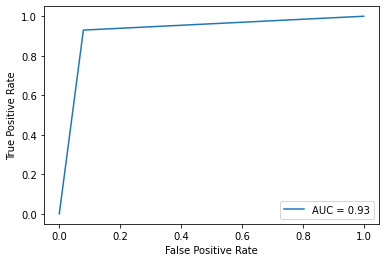

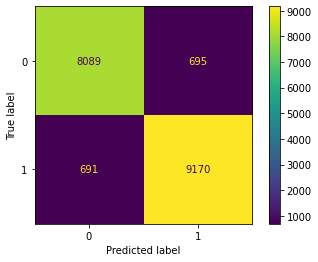

In [103]:
show_metrics(test[roles['target']].values, np.round(test_pred.data[:, 0]))

In [104]:
with open(automl_filename, 'wb') as f:
    pickle.dump(automl, f)

## BERT PyTorch Lightning
Обучим BERT с помощью PyTorch Lightning

In [ ]:
import pytorch_lightning as pl

In [16]:
tok_kwargs = dict(padding="max_length", truncation=True, max_length=128)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=origin_bert_name)
dm = TextClassificationDataModule(
    batch_size=32,
    train_file=train_path,
    validation_file=test_path,
    tokenizer=tokenizer,
    **tok_kwargs
)

In [17]:
model = TextClassificationTransformer(
    pretrained_model_name_or_path=origin_bert_name,
    num_labels=dm.num_classes
)

Using custom data configuration default-4b8fbdee0bdfbfcf
Found cached dataset json (/home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/184 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/184 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/19 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/21 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/21 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [19]:
trainer = pl.Trainer(accelerator="auto", devices="auto", max_epochs=4)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using custom data configuration default-4b8fbdee0bdfbfcf
Found cached dataset json (/home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-33192eb87ef5831b.arrow


Stringifying the column:   0%|          | 0/184 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/184 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/19 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-8b29ed82ee5ae44b.arrow
Loading cached processed dataset at /home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-6a95471788c199b0.arrow
Loading cached processed dataset at /home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0e950e99e51366f7.arrow
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name   | Type                          | Params
---------------------------------------------------------
0 | model  | BertForSequenceClassification | 167 M 
1 | prec   | Precision                     | 0     
2 | recall | Recall            

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model.hf_predict("Всем привет. Как дела?")

[{'label': 'LABEL_0', 'score': 0.9818226099014282}]

In [ ]:
model.hf_predict("Trading starts TOMORROW!💰 Let’s take a look at projected earnings for these trading accounts! ")

[{'label': 'LABEL_1', 'score': 0.7927154302597046}]

In [18]:
model.save_hf_checkpoint(modified_bert_name)
tokenizer.save_vocabulary(modified_bert_name)

## Evaluate models

In [97]:
df_eval=pd.read_json(eval_path,orient='records')
X = df_eval.text.values
y = df_eval.label.values

#### Word2Vec + CatBoost

In [29]:
model = Word2Vec.load(w2v_model_name)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
vectorizer = TfidfEmbeddingVectorizer(w2v)
X_vector = vectorize(vectorizer,df_eval.text)

In [30]:
cb_w2c = CatBoostClassifier(verbose=False)
cb_w2c.load_model(catboost_pickle_name)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      9793
           1       0.97      0.97      0.97     10924

    accuracy                           0.97     20717
   macro avg       0.97      0.97      0.97     20717
weighted avg       0.97      0.97      0.97     20717



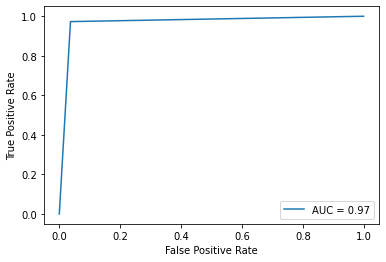

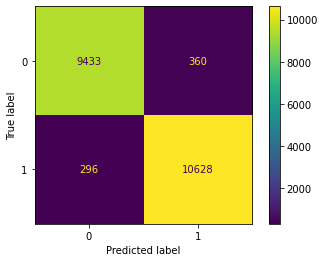

In [32]:
preds = cb_w2c.predict(X_vector)
show_metrics(y, preds)

### LAMA

In [105]:
with open(automl_filename, 'rb') as f:
    model = pickle.load(f)

In [118]:
preds=model.predict(df_eval)

[01:47:06] number of text features: 1 
[01:47:06] number of categorical features: 0 
[01:47:06] number of continuous features: 0 


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
test: 100%|██████████| 648/648 [02:42<00:00,  3.98it/s]


              precision    recall  f1-score   support

           0       0.92      0.93      0.92      9805
           1       0.93      0.93      0.93     10912

    accuracy                           0.93     20717
   macro avg       0.93      0.93      0.93     20717
weighted avg       0.93      0.93      0.93     20717



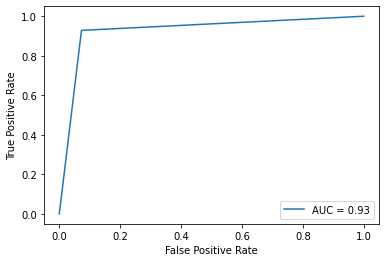

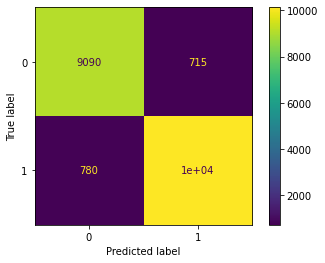

In [120]:
show_metrics(df_eval['label'], np.round(preds.data[:, 0]))

### Bert

In [62]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='./%s' % modified_bert_name)
model = TextClassificationTransformer(
    pretrained_model_name_or_path="./%s" % modified_bert_name,
    tokenizer=tokenizer
)
model.eval()
model.hf_predict('Are you spam?')

predicts = model.hf_predict(X.tolist())
preds=[int(predict['label'][-1]) for predict in predicts]

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      9922
           1       0.93      0.94      0.94     12730

    accuracy                           0.93     22652
   macro avg       0.93      0.93      0.93     22652
weighted avg       0.93      0.93      0.93     22652



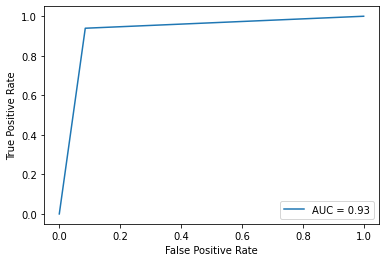

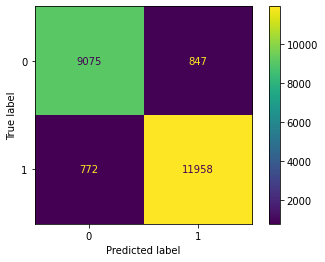

In [ ]:
show_metrics(y, preds)